In [1]:
import os

# takes care of annoying TF-GPU warnings
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# remove useless Tensorflow warning:
# WARNING:absl:Found untraced functions such as _update_step_xla, lstm_cell_1_layer_call_fn, 
# lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn, 
# lstm_cell_2_layer_call_and_return_conditional_losses while saving (showing 5 of 5). 
# These functions will not be directly callable after loading.
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

In [2]:
# very useful for managing wandb runs: https://stackoverflow.com/questions/71106179/log-two-model-runs-with-keras-wandb
import wandb
from wandb.keras import WandbCallback
os.environ["WANDB_SILENT"] = "true"

#### Logistic Regression: Formula Label Prediction (Variant 3: Stream of math types and tokens)

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path 

import tensorflow as tf

import tensorflow_datasets as tfds
import tensorflow_text as tf_text

import datetime

tfds.disable_progress_bar()
wandb_project_name = "binary_formula_classification"

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric], "")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])

#### Import Data and Preprocess Dataframe

In [5]:
def preprocess_data(corpus,
                    irrelevant_features=["mtype",]):
    # drop irrelevant columns
    corpus.drop(irrelevant_features, inplace=True, axis=1)

    # filter strings
    def process_cell(cell_str):
        stripped_f_str = cell_str[1:-1].replace("\\\\", "\\")
        f_list = stripped_f_str.split(",")
        f_list = [token.replace("'", "").replace(" ", "") for token in f_list]
        f_list = ["{" if token == "\\{" else token for token in f_list]
        f_list = ["}" if token == "\\}" else token for token in f_list]
        cell_str = " ".join(f_list)
        return cell_str

    corpus["type_tokens"] = corpus["type_tokens"].map(process_cell)
    corpus["tokens"] = corpus["tokens"].map(process_cell)

In [6]:
#print(os.getcwd())
data_p = Path("../data/") / "bin_class_data_TOKENIZED_SET_V1.csv"
data = pd.read_csv(data_p)
preprocess_data(data)
data.head()

,tokens,type_tokens,label
0,f : A \to B,func_def func_name __ANON_1 COLON mapping __AN...,1
1,f,func_name __ANON_1,1
2,g \colon B \to I,func_def func_name __ANON_1 COLON mapping __AN...,1
3,\frac { 8 ! } { ( 8 - 4 ) ! },expr_atom CMD_FRAC L_BRACE postfix expr_atom _...,1
4,f,func_name __ANON_1,1


In [7]:
print(data["type_tokens"].map(lambda x: len((x.split(" ")))).max())
print(data["tokens"].map(lambda x: len((x.split(" ")))).max())

126
104


In [8]:
SIZE_TRAIN_DS = 10000
SIZE_TEST_DS = 1000
data_as_ds = tf.data.Dataset.from_tensor_slices((data["tokens"],data["type_tokens"]))
labels_ds = tf.data.Dataset.from_tensor_slices(data["label"])
data_as_ds = tf.data.Dataset.zip((data_as_ds, labels_ds))
test_dataset = data_as_ds.take(SIZE_TEST_DS)
train_dataset = data_as_ds.skip(SIZE_TEST_DS)

In [9]:
data_as_ds.element_spec

((TensorSpec(shape=(), dtype=tf.string, name=None),
  TensorSpec(shape=(), dtype=tf.string, name=None)),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

##### Setup and Data Preparation

In [10]:
for (example_token, example_type), label in train_dataset.take(5):
    print("text: ", example_token.numpy())
    print("type: ", example_type.numpy())
    print("label: ", label.numpy())

text:  b'f'
type:  b'func_name __ANON_1'
label:  1
text:  b'f'
type:  b'func_name __ANON_1'
label:  1
text:  b'f : X \\rightarrow Y'
type:  b'func_def func_name __ANON_1 COLON mapping __ANON_0 TO __ANON_0'
label:  1
text:  b'mathbb{R'
type:  b'set_constant SET_BASIC'
label:  1
text:  b'g : \\mathbb{N} \\to X'
type:  b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0'
label:  1


In [11]:
BUFFER_SIZE = SIZE_TRAIN_DS
BATCH_SIZE = 64
STEPS_PER_EPOCH = np.floor(SIZE_TRAIN_DS/BATCH_SIZE)
VAL_STEPS_PER_EPOCH = np.floor(SIZE_TEST_DS/BATCH_SIZE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

##### Text Encoding

In [12]:
# for int encoder
TYPE_TOKENS_MAX_SEQ_LEN = 130 
TOKENS_MAX_SEQ_LEN = 110

# for other encoders 
TYPE_TOKENS_PAD_TO_MAX_TOKENS = 100 
TOKENS_PAD_TO_MAX_TOKENS = 150
BIGRAM_PAD_TO_MAX_TOKENS = 350

In [13]:
def create_encoder(output_mode_str, n_grams, mode):
    if output_mode_str == "int":
        VOCAB_SIZE = 200
        if mode == "token":
            max_seq_len = TOKENS_MAX_SEQ_LEN
        elif mode == "type":
            max_seq_len = TYPE_TOKENS_MAX_SEQ_LEN

        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            output_sequence_length = max_seq_len,
            split="whitespace",
            max_tokens=VOCAB_SIZE)
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if output_mode_str == "count" and n_grams == 2:
        max_seq_len = BIGRAM_PAD_TO_MAX_TOKENS
        encoder = tf.keras.layers.TextVectorization(
            standardize=None,
            output_mode=output_mode_str,
            ngrams = n_grams,
            pad_to_max_tokens = max_seq_len,
            split="whitespace",
            max_tokens=max_seq_len)
        
        #TODO: adapt for different inputs
        if mode == "token": 
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
        elif mode == "type":
            encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
        return encoder
    
    if mode == "token":
        max_seq_len = TOKENS_PAD_TO_MAX_TOKENS
    elif mode == "type":
        max_seq_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

    encoder = tf.keras.layers.TextVectorization(
        standardize=None,
        output_mode=output_mode_str,
        ngrams = n_grams,
        pad_to_max_tokens = max_seq_len,
        split="whitespace",
        max_tokens=max_seq_len)
    #TODO: adapt for different inputs
    if mode == "token": 
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[0])) # removes the label column through transformation: text, label -> text
    elif mode == "type":
        encoder.adapt(train_dataset.map(lambda inputs, label: inputs[1])) # removes the label column through transformation: text, label -> text
    
    return encoder


    

##### Representation 1: Use integer indices encoding

In [14]:
encoder_int_tokens = create_encoder("int", None, "token")
encoder_int_types = create_encoder("int", None, "type")

vocab_tokens = np.array(encoder_int_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_int_tokens.get_vocabulary())
vocab_types = np.array(encoder_int_types.get_vocabulary())
vocab_size_types = len(encoder_int_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
tokens (voc size):  123
types (voc size):  59


In [15]:
encoded_example_token = encoder_int_tokens(example_token).numpy()
encoded_example_types = encoder_int_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[18  8 34 13 23  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
(110,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0', shape=(), dtype=string)
[ 9  5  2  7  8 21 22 10  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0]
(130,)


##### Representation 2: Binary Count Vectorizer

In [16]:
encoder_multi_hot_tokens = create_encoder("multi_hot", None, "token")
encoder_multi_hot_types = create_encoder("multi_hot", None, "type")

vocab_tokens = np.array(encoder_multi_hot_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_multi_hot_tokens.get_vocabulary())
vocab_types = np.array(encoder_multi_hot_types.get_vocabulary())
vocab_size_types = len(encoder_multi_hot_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  122
types (voc size):  58


In [17]:
encoded_example_token = encoder_multi_hot_tokens(example_token).numpy()
encoded_example_types = encoder_multi_hot_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(150,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100,)


##### Representation 3: Frequency Count Vectorizer

In [18]:
encoder_count_tokens = create_encoder("count", None, "token")
encoder_count_types = create_encoder("count", None, "type")

vocab_tokens = np.array(encoder_count_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_count_tokens.get_vocabulary())
vocab_types = np.array(encoder_count_types.get_vocabulary())
vocab_size_types = len(encoder_count_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  122
types (voc size):  58


In [19]:
encoded_example_token = encoder_count_tokens(example_token).numpy()
encoded_example_types = encoder_count_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
(150,)
types: 
tf.Tensor(b'func_def func_name __ANON_1 COLON mapping set_constant SET_BASIC TO __ANON_0', shape=(), dtype=string)
[0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(100,)


##### Representation 4: Bigrams Frequency Count Vectorizer

In [20]:
encoder_bigrams_tokens = create_encoder("count", (2), "token")
encoder_bigrams_types = create_encoder("count", (2), "type")

vocab_tokens = np.array(encoder_bigrams_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_bigrams_tokens.get_vocabulary())
vocab_types = np.array(encoder_bigrams_types.get_vocabulary())
vocab_size_types = len(encoder_bigrams_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  350
types (voc size):  350


In [21]:
encoded_example_token = encoder_bigrams_tokens(example_token).numpy()
encoded_example_types = encoder_bigrams_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

##### Representation 5: Tf-Idf Vectorizer

In [22]:
encoder_tf_idf_tokens = create_encoder("tf_idf", None, "token")
encoder_tf_idf_types = create_encoder("tf_idf", None, "type")

vocab_tokens = np.array(encoder_tf_idf_tokens.get_vocabulary())
vocab_size_tokens = len(encoder_tf_idf_tokens.get_vocabulary())
vocab_types = np.array(encoder_tf_idf_types.get_vocabulary())
vocab_size_types = len(encoder_tf_idf_types.get_vocabulary())

print("tokens (voc size): ", vocab_size_tokens)
print("types (voc size): ", vocab_size_types)

tokens (voc size):  122
types (voc size):  58


In [23]:
encoded_example_token = encoder_tf_idf_tokens(example_token).numpy()
encoded_example_types = encoder_tf_idf_types(example_type).numpy()

print("tokens: ")
print(example_token)
print(encoded_example_token)
print(encoded_example_token.shape)

print("types: ")
print(example_type)
print(encoded_example_types)
print(encoded_example_types.shape)

tokens: 
tf.Tensor(b'g : \\mathbb{N} \\to X', shape=(), dtype=string)
[0.        0.        0.        0.        0.        0.        0.
 2.0530765 0.        0.        0.        0.        2.2306762 0.
 0.        0.        0.        2.7030165 0.        0.        0.
 0.        3.0641932 0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        3.845844  0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0. 

##### Model (Bidirectional LSTM with one layer)

 **Define and compile model**

In [24]:
def create_model(tokens_encoder, types_encoder, tokens_size, types_size, add_inp_emb_dim=1):
    embedding_input_dim = tokens_size + types_size + add_inp_emb_dim

    tokens_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    tokens_vectorized = tokens_encoder(tokens_model_input)

    types_model_input = tf.keras.layers.Input(dtype=tf.string, shape=(1,))
    types_vectorized = types_encoder(types_model_input)
    merged = tf.keras.layers.Concatenate(axis=1)([tokens_vectorized, types_vectorized])

    embedded = tf.keras.layers.Embedding(input_dim= embedding_input_dim,
                                         output_dim=64,
                                         # user masking to handle the variable sequence lengths
                                         mask_zero=True)(merged)
    
    dropout1 = tf.keras.layers.Dropout(0.2)(embedded)
    globalmaxpooling = tf.keras.layers.GlobalMaxPooling1D()(dropout1)
    dropout2 = tf.keras.layers.Dropout(0.2)(globalmaxpooling)
    model_output = tf.keras.layers.Dense(1)(dropout2)

    model = tf.keras.models.Model(inputs=[tokens_model_input, types_model_input], outputs=model_output)
    return model


 **Train the model**

##### Experiment 1: Use integer indices for encoding tokens

In [25]:
### TENSORBOARD USAGE
#log_dir = "4_nlp_rnns/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
#tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [26]:
tokens_input_len = TOKENS_MAX_SEQ_LEN 
type_input_len = TYPE_TOKENS_MAX_SEQ_LEN

model = create_model(encoder_int_tokens, encoder_int_types,tokens_input_len, type_input_len)
"""
sample_text = "( A \cup B ) \cap (C \cup D )"
# predict on a sample formula using untrained model
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\nsample_text = "( A \\cup B ) \\cap (C \\cup D )"\n# predict on a sample formula using untrained model\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 110)         0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 text_vectorization_1 (TextVect  (None, 130)         0           ['input_2[0][0]']            

In [28]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [29]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "int",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
153/156 [============================>.] - ETA: 0s - loss: 0.5904 - accuracy: 0.5946INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 4s 20ms/step - loss: 0.5896 - accuracy: 0.5968 - val_loss: 0.5814 - val_accuracy: 0.4344
Epoch 2/200
151/156 [============================>.] - ETA: 0s - loss: 0.4935 - accuracy: 0.7421INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.4918 - accuracy: 0.7431 - val_loss: 0.4975 - val_accuracy: 0.7990
Epoch 3/200
154/156 [============================>.] - ETA: 0s - loss: 0.4694 - accuracy: 0.7513INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 15ms/step - loss: 0.4696 - accuracy: 0.7506 - val_loss: 0.4733 - val_accuracy: 0.8260
Epoch 4/200
156/156 [==============================] - 1s 9ms/step - loss: 0.4592 - accuracy: 0.7590 - val_loss: 0.4817 - val_accuracy: 0.6104
Epoch 5/200
154/156 [============================>.] - ETA: 0s - loss: 0.4550 - accuracy: 0.7590INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.4548 - accuracy: 0.7591 - val_loss: 0.4696 - val_accuracy: 0.6115
Epoch 6/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4525 - accuracy: 0.7598 - val_loss: 0.4739 - val_accuracy: 0.6135
Epoch 7/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4487 - accuracy: 0.7592 - val_loss: 0.4735 - val_accuracy: 0.6135
Epoch 8/200
155/156 [============================>.] - ETA: 0s - loss: 0.4467 - accuracy: 0.7652INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.4475 - accuracy: 0.7647 - val_loss: 0.4682 - val_accuracy: 0.6177
Epoch 9/200
156/156 [==============================] - 1s 7ms/step - loss: 0.4471 - accuracy: 0.7569 - val_loss: 0.4695 - val_accuracy: 0.6156
Epoch 10/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4455 - accuracy: 0.7664 - val_loss: 0.4715 - val_accuracy: 0.6146
Epoch 11/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4436 - accuracy: 0.7623 - val_loss: 0.4707 - val_accuracy: 0.6115
Epoch 12/200
150/156 [===========================>..] - ETA: 0s - loss: 0.4422 - accuracy: 0.7628INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.4436 - accuracy: 0.7621 - val_loss: 0.4660 - val_accuracy: 0.8313
Epoch 13/200
154/156 [============================>.] - ETA: 0s - loss: 0.4417 - accuracy: 0.7646INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.4415 - accuracy: 0.7638 - val_loss: 0.4624 - val_accuracy: 0.6135
Epoch 14/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4407 - accuracy: 0.7634 - val_loss: 0.4772 - val_accuracy: 0.6062
Epoch 15/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4438 - accuracy: 0.7605 - val_loss: 0.4821 - val_accuracy: 0.6021
Epoch 16/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4397 - accuracy: 0.7698 - val_loss: 0.4822 - val_accuracy: 0.6021
Epoch 17/200
156/156 [==============================] - 1s 9ms/step - loss: 0.4411 - accuracy: 0.7699 - val_loss: 0.4710 - val_accuracy: 0.6073
Epoch 18/200
156/156 [==============================] - 2s 10ms/step - loss: 0.4405 - accuracy: 0.7717 - val_loss: 0.4724 - val_accuracy: 0.6042
Epoch 19/200
156/156 [==============================] - 2s 9ms/step - loss: 0.4412 - accuracy: 0.7696 - val_loss: 0.4809 - val_accuracy: 0.6042
Epo

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.4381 - accuracy: 0.7675 - val_loss: 0.4523 - val_accuracy: 0.8240
Epoch 26/200
156/156 [==============================] - 2s 9ms/step - loss: 0.4392 - accuracy: 0.7696 - val_loss: 0.4790 - val_accuracy: 0.6042
Epoch 27/200
156/156 [==============================] - 2s 9ms/step - loss: 0.4372 - accuracy: 0.7702 - val_loss: 0.4729 - val_accuracy: 0.8177
Epoch 28/200
154/156 [============================>.] - ETA: 0s - loss: 0.4365 - accuracy: 0.7742INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_230544-edrm1l4a/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.4366 - accuracy: 0.7739 - val_loss: 0.4479 - val_accuracy: 0.8229
Epoch 29/200
156/156 [==============================] - 2s 11ms/step - loss: 0.4374 - accuracy: 0.7720 - val_loss: 0.4734 - val_accuracy: 0.6042
Epoch 30/200
156/156 [==============================] - 2s 10ms/step - loss: 0.4371 - accuracy: 0.7683 - val_loss: 0.4641 - val_accuracy: 0.6042
Epoch 31/200
156/156 [==============================] - 2s 9ms/step - loss: 0.4383 - accuracy: 0.7733 - val_loss: 0.4684 - val_accuracy: 0.6042
Epoch 32/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4371 - accuracy: 0.7710 - val_loss: 0.4851 - val_accuracy: 0.6010
Epoch 33/200
156/156 [==============================] - 1s 8ms/step - loss: 0.4374 - accuracy: 0.7645 - val_loss: 0.4610 - val_accuracy: 0.8219
Epoch 34/200
156/156 [==============================] - 1s 9ms/step - loss: 0.4377 - accuracy: 0.7736 - val_loss: 0.4726 - val_accuracy: 0.6042
Ep

In [30]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 2ms/step - loss: 0.4694 - accuracy: 0.6042
Test Loss: 0.46943292021751404
Test Accuracy: 0.6041666865348816


(0.0, 0.5974564850330353)

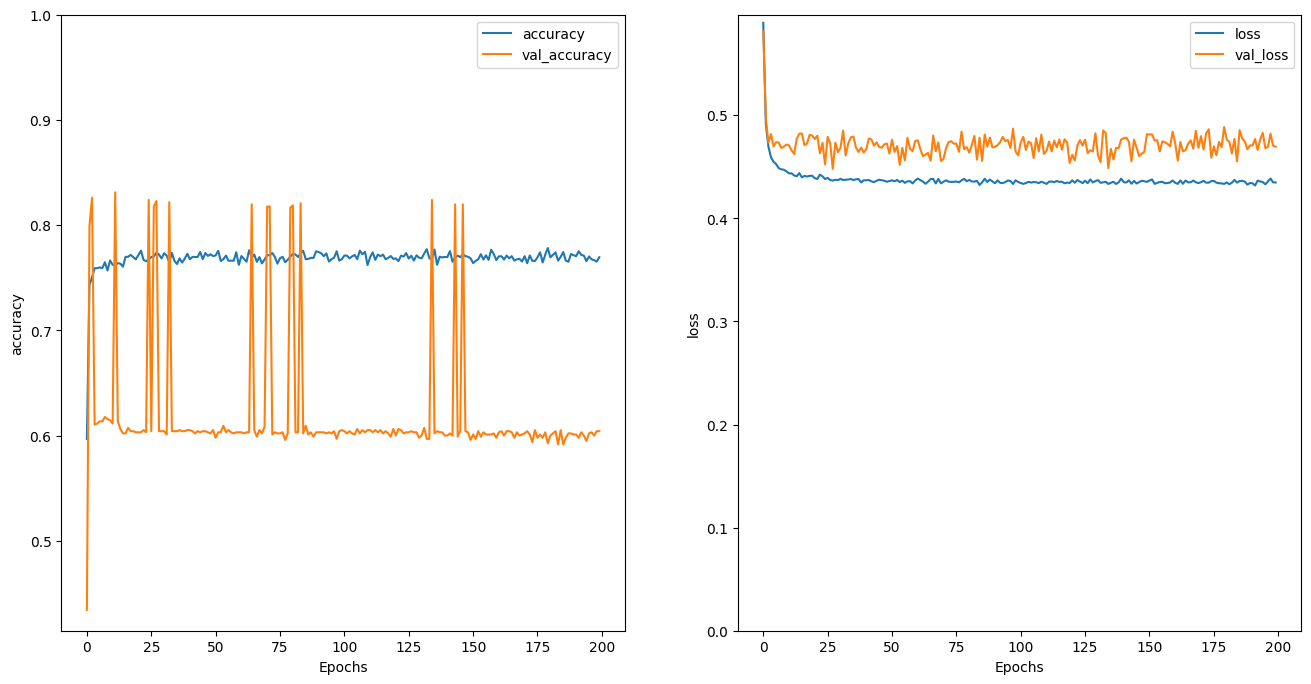

In [31]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [32]:

# predict on a sample text without padding
"""
predictions = model.predict((np.array([example_token]), np.array([example_type])))
print(predictions[0])
"""

'\npredictions = model.predict((np.array([example_token]), np.array([example_type])))\nprint(predictions[0])\n'

##### Experiment 2: Use binary count vectorizer for encoding

In [33]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model = create_model(encoder_multi_hot_tokens, encoder_multi_hot_types,tokens_input_len, type_input_len) # maybe add 30
# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [34]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [35]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "multi_hot",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6892 - accuracy: 0.5497INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231105-ywgmuu9x/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231105-ywgmuu9x/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.6891 - accuracy: 0.5501 - val_loss: 0.8017 - val_accuracy: 0.0000e+00
Epoch 2/200
155/156 [============================>.] - ETA: 0s - loss: 0.6883 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231105-ywgmuu9x/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231105-ywgmuu9x/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6882 - accuracy: 0.5505 - val_loss: 0.7990 - val_accuracy: 0.0000e+00
Epoch 3/200
153/156 [============================>.] - ETA: 0s - loss: 0.6885 - accuracy: 0.5495INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231105-ywgmuu9x/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231105-ywgmuu9x/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6885 - accuracy: 0.5497 - val_loss: 0.7563 - val_accuracy: 0.0000e+00
Epoch 4/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6890 - accuracy: 0.5498 - val_loss: 0.8128 - val_accuracy: 0.0000e+00
Epoch 5/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6885 - accuracy: 0.5500 - val_loss: 0.8230 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6887 - accuracy: 0.5497 - val_loss: 0.8289 - val_accuracy: 0.0000e+00
Epoch 7/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6883 - accuracy: 0.5502 - val_loss: 0.8011 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6883 - accuracy: 0.5502 - val_loss: 0.8513 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6884 - accuracy: 0.5495 - val_loss: 0.8284 - val_acc

In [36]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 2ms/step - loss: 0.7991 - accuracy: 0.0000e+00
Test Loss: 0.7991421222686768
Test Accuracy: 0.0


(0.0, 0.8778083920478821)

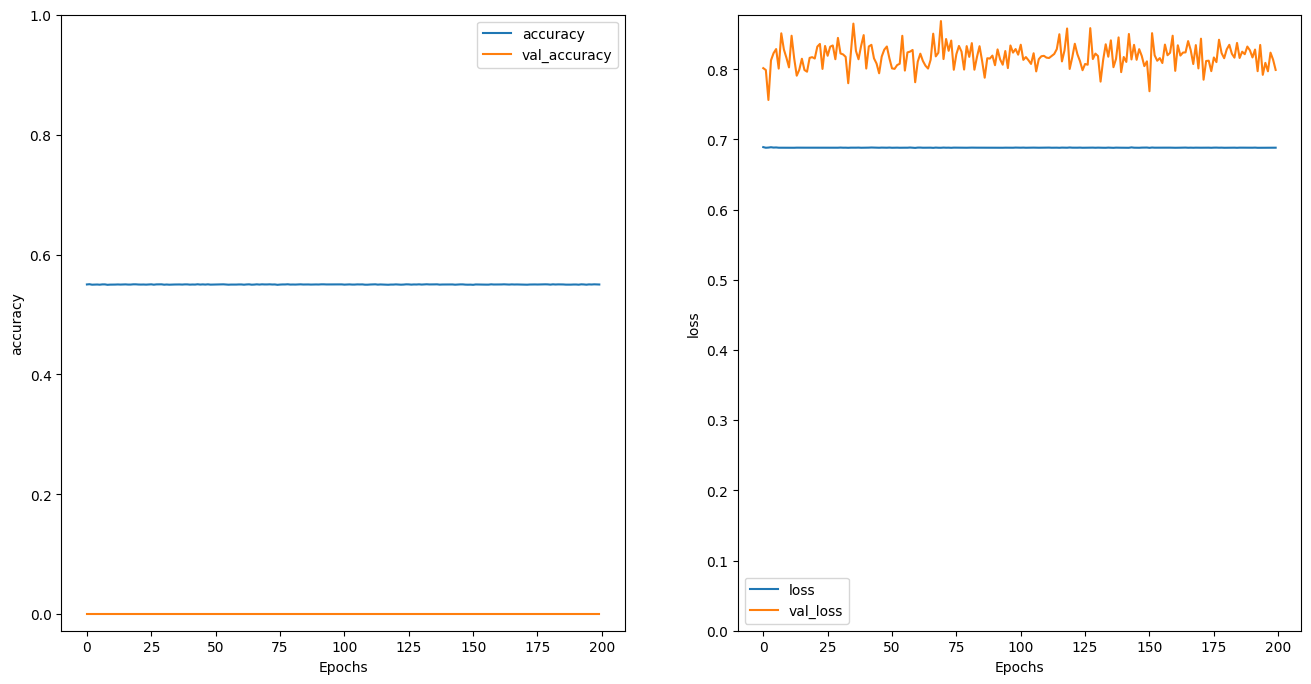

In [37]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [38]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

##### Experiment 3:

In [39]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model = create_model(encoder_count_tokens, encoder_count_types,tokens_input_len, type_input_len) # maybe add 30
# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [40]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [41]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
151/156 [============================>.] - ETA: 0s - loss: 0.6654 - accuracy: 0.5504INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6655 - accuracy: 0.5499 - val_loss: 0.6716 - val_accuracy: 0.0000e+00
Epoch 2/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6595 - accuracy: 0.5501 - val_loss: 0.6871 - val_accuracy: 0.0000e+00
Epoch 3/200
155/156 [============================>.] - ETA: 0s - loss: 0.6595 - accuracy: 0.5499INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 15ms/step - loss: 0.6598 - accuracy: 0.5497 - val_loss: 0.6592 - val_accuracy: 0.0000e+00
Epoch 4/200
155/156 [============================>.] - ETA: 0s - loss: 0.6589 - accuracy: 0.5499INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.6589 - accuracy: 0.5502 - val_loss: 0.6527 - val_accuracy: 0.0000e+00
Epoch 5/200
152/156 [============================>.] - ETA: 0s - loss: 0.6583 - accuracy: 0.5494INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6583 - accuracy: 0.5497 - val_loss: 0.6426 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6585 - accuracy: 0.5498 - val_loss: 0.6788 - val_accuracy: 0.0000e+00
Epoch 7/200
155/156 [============================>.] - ETA: 0s - loss: 0.6597 - accuracy: 0.5495INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 15ms/step - loss: 0.6598 - accuracy: 0.5499 - val_loss: 0.6388 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6587 - accuracy: 0.5499 - val_loss: 0.6703 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6573 - accuracy: 0.5503 - val_loss: 0.6646 - val_accuracy: 0.0000e+00
Epoch 10/200
155/156 [============================>.] - ETA: 0s - loss: 0.6580 - accuracy: 0.5497INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.6581 - accuracy: 0.5499 - val_loss: 0.6198 - val_accuracy: 0.0000e+00
Epoch 11/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6578 - accuracy: 0.5499 - val_loss: 0.6634 - val_accuracy: 0.0000e+00
Epoch 12/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6582 - accuracy: 0.5501 - val_loss: 0.6590 - val_accuracy: 0.0000e+00
Epoch 13/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6590 - accuracy: 0.5499 - val_loss: 0.6606 - val_accuracy: 0.0000e+00
Epoch 14/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6579 - accuracy: 0.5500 - val_loss: 0.6731 - val_accuracy: 0.0000e+00
Epoch 15/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6582 - accuracy: 0.5503 - val_loss: 0.6637 - val_accuracy: 0.0000e+00
Epoch 16/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6596 - accuracy: 0.5499 - val_loss: 0.6290 - v

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 21ms/step - loss: 0.6591 - accuracy: 0.5499 - val_loss: 0.6026 - val_accuracy: 0.0000e+00
Epoch 34/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6579 - accuracy: 0.5503 - val_loss: 0.6623 - val_accuracy: 0.0000e+00
Epoch 35/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6593 - accuracy: 0.5499 - val_loss: 0.6509 - val_accuracy: 0.0000e+00
Epoch 36/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6578 - accuracy: 0.5502 - val_loss: 0.6235 - val_accuracy: 0.0000e+00
Epoch 37/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6590 - accuracy: 0.5502 - val_loss: 0.6484 - val_accuracy: 0.0000e+00
Epoch 38/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6580 - accuracy: 0.5500 - val_loss: 0.6538 - val_accuracy: 0.0000e+00
Epoch 39/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6588 - accuracy: 0.5500 - val_loss: 0.6572 - v

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6579 - accuracy: 0.5498 - val_loss: 0.5966 - val_accuracy: 0.3781
Epoch 107/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6572 - accuracy: 0.5496 - val_loss: 0.6473 - val_accuracy: 0.0000e+00
Epoch 108/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6583 - accuracy: 0.5499 - val_loss: 0.6307 - val_accuracy: 0.0000e+00
Epoch 109/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6582 - accuracy: 0.5498 - val_loss: 0.6161 - val_accuracy: 0.0000e+00
Epoch 110/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6576 - accuracy: 0.5500 - val_loss: 0.6149 - val_accuracy: 0.0000e+00
Epoch 111/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6584 - accuracy: 0.5504 - val_loss: 0.6130 - val_accuracy: 0.0000e+00
Epoch 112/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6585 - accuracy: 0.5499 - val_loss: 0.6157 -

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6587 - accuracy: 0.5504 - val_loss: 0.5840 - val_accuracy: 0.3781
Epoch 114/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6580 - accuracy: 0.5497 - val_loss: 0.6062 - val_accuracy: 0.0000e+00
Epoch 115/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6584 - accuracy: 0.5500 - val_loss: 0.6228 - val_accuracy: 0.0000e+00
Epoch 116/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6588 - accuracy: 0.5501 - val_loss: 0.5980 - val_accuracy: 0.0000e+00
Epoch 117/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6588 - accuracy: 0.5499 - val_loss: 0.6143 - val_accuracy: 0.0000e+00
Epoch 118/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6585 - accuracy: 0.5500 - val_loss: 0.5993 - val_accuracy: 0.0000e+00
Epoch 119/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6585 - accuracy: 0.5500 - val_loss: 0.6073 -

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6591 - accuracy: 0.5501 - val_loss: 0.5765 - val_accuracy: 0.3781
Epoch 122/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6585 - accuracy: 0.5499 - val_loss: 0.6030 - val_accuracy: 0.0000e+00
Epoch 123/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6578 - accuracy: 0.5505 - val_loss: 0.6201 - val_accuracy: 0.0000e+00
Epoch 124/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6574 - accuracy: 0.5498 - val_loss: 0.6097 - val_accuracy: 0.3781
Epoch 125/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6584 - accuracy: 0.5498 - val_loss: 0.5919 - val_accuracy: 0.3781
Epoch 126/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6582 - accuracy: 0.5497 - val_loss: 0.6058 - val_accuracy: 0.0000e+00
Epoch 127/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6595 - accuracy: 0.5499 - val_loss: 0.5900 - val_acc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6594 - accuracy: 0.5501 - val_loss: 0.5677 - val_accuracy: 0.3781
Epoch 132/200
152/156 [============================>.] - ETA: 0s - loss: 0.6594 - accuracy: 0.5494INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6594 - accuracy: 0.5498 - val_loss: 0.5655 - val_accuracy: 0.9271
Epoch 133/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6572 - accuracy: 0.5499 - val_loss: 0.5894 - val_accuracy: 0.9271
Epoch 134/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6586 - accuracy: 0.5498 - val_loss: 0.5674 - val_accuracy: 0.9271
Epoch 135/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6584 - accuracy: 0.5499 - val_loss: 0.5782 - val_accuracy: 0.9271
Epoch 136/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6582 - accuracy: 0.5498 - val_loss: 0.5898 - val_accuracy: 0.9271
Epoch 137/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6582 - accuracy: 0.5497 - val_loss: 0.5749 - val_accuracy: 0.9271
Epoch 138/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6590 - accuracy: 0.5503 - val_loss: 0.5962 - val_accuracy: 0.927

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6580 - accuracy: 0.5498 - val_loss: 0.5652 - val_accuracy: 0.9271
Epoch 150/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6574 - accuracy: 0.5498 - val_loss: 0.5814 - val_accuracy: 0.9271
Epoch 151/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6575 - accuracy: 0.5499 - val_loss: 0.5921 - val_accuracy: 0.9271
Epoch 152/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6583 - accuracy: 0.5496 - val_loss: 0.5905 - val_accuracy: 0.9271
Epoch 153/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6583 - accuracy: 0.5503 - val_loss: 0.6035 - val_accuracy: 0.5490
Epoch 154/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6583 - accuracy: 0.5502 - val_loss: 0.5832 - val_accuracy: 0.9271
Epoch 155/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6593 - accuracy: 0.5501 - val_loss: 0.5955 - val_accuracy: 0.927

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_231547-gxilwgkp/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6570 - accuracy: 0.5502 - val_loss: 0.5578 - val_accuracy: 0.9271
Epoch 178/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6597 - accuracy: 0.5502 - val_loss: 0.6060 - val_accuracy: 0.9271
Epoch 179/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6593 - accuracy: 0.5500 - val_loss: 0.6130 - val_accuracy: 0.0000e+00
Epoch 180/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6589 - accuracy: 0.5503 - val_loss: 0.5689 - val_accuracy: 0.9271
Epoch 181/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6583 - accuracy: 0.5499 - val_loss: 0.5665 - val_accuracy: 0.9271
Epoch 182/200
156/156 [==============================] - 1s 9ms/step - loss: 0.6589 - accuracy: 0.5499 - val_loss: 0.5630 - val_accuracy: 0.9271
Epoch 183/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6580 - accuracy: 0.5499 - val_loss: 0.5964 - val_accuracy: 0

In [42]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 2ms/step - loss: 0.5579 - accuracy: 0.9271
Test Loss: 0.5579007863998413
Test Accuracy: 0.9270833134651184


(0.0, 0.6935673922300338)

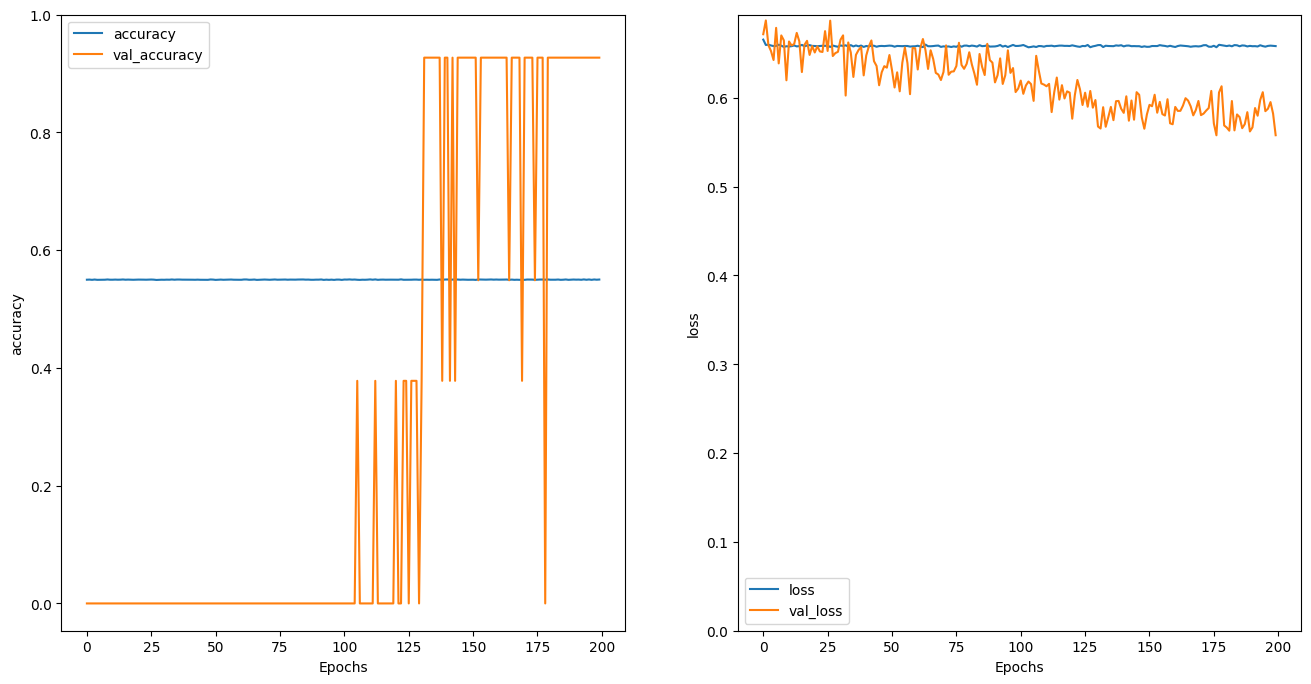

In [43]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [44]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

##### Experiment 4:

In [45]:
tokens_input_len = BIGRAM_PAD_TO_MAX_TOKENS
type_input_len = BIGRAM_PAD_TO_MAX_TOKENS

model = create_model(encoder_bigrams_tokens, encoder_bigrams_types,tokens_input_len, type_input_len) # maybe add 30

# predict on a sample formula using untrained model
#predictions = model.predict(np.array([sample_text]))
#print(predictions[0])

In [46]:
LEARNING_RATE = 1e-2
NUM_EPOCHS = 200

sample_text = "( A \cup B ) \cap (C \cup D )"
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [47]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_6 (TextVect  (None, 350)         0           ['input_7[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_7 (TextVect  (None, 350)         0           ['input_8[0][0]']          

In [48]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "bigram_count",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
155/156 [============================>.] - ETA: 0s - loss: 0.6655 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 6s 32ms/step - loss: 0.6655 - accuracy: 0.5498 - val_loss: 0.6881 - val_accuracy: 0.0000e+00
Epoch 2/200
154/156 [============================>.] - ETA: 0s - loss: 0.6613 - accuracy: 0.5501INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6613 - accuracy: 0.5499 - val_loss: 0.6778 - val_accuracy: 0.0000e+00
Epoch 3/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6609 - accuracy: 0.5500 - val_loss: 0.6796 - val_accuracy: 0.0000e+00
Epoch 4/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6609 - accuracy: 0.5497 - val_loss: 0.6850 - val_accuracy: 0.0000e+00
Epoch 5/200
155/156 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.5504INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 32ms/step - loss: 0.6609 - accuracy: 0.5500 - val_loss: 0.6641 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6605 - accuracy: 0.5497 - val_loss: 0.6713 - val_accuracy: 0.0000e+00
Epoch 7/200
155/156 [============================>.] - ETA: 0s - loss: 0.6611 - accuracy: 0.5505INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 30ms/step - loss: 0.6611 - accuracy: 0.5500 - val_loss: 0.6620 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - ETA: 0s - loss: 0.6603 - accuracy: 0.5500INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6603 - accuracy: 0.5500 - val_loss: 0.6513 - val_accuracy: 0.0000e+00
Epoch 9/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6606 - accuracy: 0.5499 - val_loss: 0.6739 - val_accuracy: 0.0000e+00
Epoch 10/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6606 - accuracy: 0.5499 - val_loss: 0.6650 - val_accuracy: 0.0000e+00
Epoch 11/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6596 - accuracy: 0.5499 - val_loss: 0.6949 - val_accuracy: 0.0000e+00
Epoch 12/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6616 - accuracy: 0.5504 - val_loss: 0.6668 - val_accuracy: 0.0000e+00
Epoch 13/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6616 - accuracy: 0.5499 - val_loss: 0.6579 - val_accuracy: 0.0000e+00
Epoch 14/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6611 - accuracy: 0.5496 - val_loss: 0.688

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6605 - accuracy: 0.5501 - val_loss: 0.6498 - val_accuracy: 0.0000e+00
Epoch 16/200
156/156 [==============================] - ETA: 0s - loss: 0.6605 - accuracy: 0.5503INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 32ms/step - loss: 0.6605 - accuracy: 0.5503 - val_loss: 0.6274 - val_accuracy: 0.0000e+00
Epoch 17/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6603 - accuracy: 0.5500 - val_loss: 0.6369 - val_accuracy: 0.0000e+00
Epoch 18/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6606 - accuracy: 0.5498 - val_loss: 0.6714 - val_accuracy: 0.0000e+00
Epoch 19/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6605 - accuracy: 0.5500 - val_loss: 0.6464 - val_accuracy: 0.0000e+00
Epoch 20/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6607 - accuracy: 0.5501 - val_loss: 0.6464 - val_accuracy: 0.0000e+00
Epoch 21/200
156/156 [==============================] - 3s 22ms/step - loss: 0.6604 - accuracy: 0.5499 - val_loss: 0.6670 - val_accuracy: 0.0000e+00
Epoch 22/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6607 - accuracy: 0.5500 - val_loss: 0.67

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6599 - accuracy: 0.5500 - val_loss: 0.6239 - val_accuracy: 0.0000e+00
Epoch 43/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6601 - accuracy: 0.5500 - val_loss: 0.6345 - val_accuracy: 0.0000e+00
Epoch 44/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6603 - accuracy: 0.5503 - val_loss: 0.6661 - val_accuracy: 0.0000e+00
Epoch 45/200
156/156 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.5498INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6600 - accuracy: 0.5498 - val_loss: 0.6226 - val_accuracy: 0.0000e+00
Epoch 46/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6606 - accuracy: 0.5500 - val_loss: 0.6686 - val_accuracy: 0.0000e+00
Epoch 47/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6611 - accuracy: 0.5495 - val_loss: 0.6498 - val_accuracy: 0.0000e+00
Epoch 48/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6604 - accuracy: 0.5501 - val_loss: 0.6698 - val_accuracy: 0.0000e+00
Epoch 49/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6607 - accuracy: 0.5500 - val_loss: 0.6500 - val_accuracy: 0.0000e+00
Epoch 50/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6607 - accuracy: 0.5501 - val_loss: 0.6377 - val_accuracy: 0.0000e+00
Epoch 51/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6604 - accuracy: 0.5500 - val_loss: 0.64

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6603 - accuracy: 0.5503 - val_loss: 0.6210 - val_accuracy: 0.0000e+00
Epoch 124/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6618 - accuracy: 0.5503 - val_loss: 0.6458 - val_accuracy: 0.0000e+00
Epoch 125/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6603 - accuracy: 0.5501 - val_loss: 0.6479 - val_accuracy: 0.0000e+00
Epoch 126/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6612 - accuracy: 0.5495 - val_loss: 0.6589 - val_accuracy: 0.0000e+00
Epoch 127/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6601 - accuracy: 0.5500 - val_loss: 0.6495 - val_accuracy: 0.0000e+00
Epoch 128/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6609 - accuracy: 0.5495 - val_loss: 0.6451 - val_accuracy: 0.0000e+00
Epoch 129/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6605 - accuracy: 0.5499 - val_loss

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 31ms/step - loss: 0.6602 - accuracy: 0.5503 - val_loss: 0.6120 - val_accuracy: 0.0000e+00
Epoch 139/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6598 - accuracy: 0.5500 - val_loss: 0.6448 - val_accuracy: 0.0000e+00
Epoch 140/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6593 - accuracy: 0.5500 - val_loss: 0.6375 - val_accuracy: 0.0000e+00
Epoch 141/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6597 - accuracy: 0.5503 - val_loss: 0.6204 - val_accuracy: 0.0000e+00
Epoch 142/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6608 - accuracy: 0.5503 - val_loss: 0.6468 - val_accuracy: 0.0000e+00
Epoch 143/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6606 - accuracy: 0.5500 - val_loss: 0.6201 - val_accuracy: 0.0000e+00
Epoch 144/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6594 - accuracy: 0.5499 - val_loss

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6608 - accuracy: 0.5502 - val_loss: 0.6116 - val_accuracy: 0.0000e+00
Epoch 149/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6595 - accuracy: 0.5498 - val_loss: 0.6396 - val_accuracy: 0.0000e+00
Epoch 150/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6601 - accuracy: 0.5500 - val_loss: 0.6491 - val_accuracy: 0.0000e+00
Epoch 151/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6602 - accuracy: 0.5499 - val_loss: 0.6516 - val_accuracy: 0.0000e+00
Epoch 152/200
154/156 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.5509INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 29ms/step - loss: 0.6609 - accuracy: 0.5499 - val_loss: 0.6072 - val_accuracy: 0.0000e+00
Epoch 153/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6607 - accuracy: 0.5499 - val_loss: 0.6398 - val_accuracy: 0.0000e+00
Epoch 154/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6600 - accuracy: 0.5500 - val_loss: 0.6157 - val_accuracy: 0.0000e+00
Epoch 155/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6611 - accuracy: 0.5499 - val_loss: 0.6210 - val_accuracy: 0.0000e+00
Epoch 156/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6595 - accuracy: 0.5498 - val_loss: 0.6318 - val_accuracy: 0.0000e+00
Epoch 157/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6613 - accuracy: 0.5496 - val_loss: 0.6428 - val_accuracy: 0.0000e+00
Epoch 158/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6606 - accuracy: 0.5498 - val_loss

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 30ms/step - loss: 0.6599 - accuracy: 0.5503 - val_loss: 0.6031 - val_accuracy: 0.0000e+00
Epoch 160/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6604 - accuracy: 0.5502 - val_loss: 0.6196 - val_accuracy: 0.0000e+00
Epoch 161/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6605 - accuracy: 0.5501 - val_loss: 0.6105 - val_accuracy: 0.3688
Epoch 162/200
156/156 [==============================] - 4s 22ms/step - loss: 0.6601 - accuracy: 0.5498 - val_loss: 0.6588 - val_accuracy: 0.0000e+00
Epoch 163/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6595 - accuracy: 0.5500 - val_loss: 0.6376 - val_accuracy: 0.0000e+00
Epoch 164/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6604 - accuracy: 0.5496 - val_loss: 0.6389 - val_accuracy: 0.0000e+00
Epoch 165/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6610 - accuracy: 0.5496 - val_loss: 0.

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_232102-7205up9o/files/model-best/assets


156/156 [==============================] - 5s 33ms/step - loss: 0.6588 - accuracy: 0.5501 - val_loss: 0.5882 - val_accuracy: 0.3688
Epoch 170/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6613 - accuracy: 0.5497 - val_loss: 0.6109 - val_accuracy: 0.0000e+00
Epoch 171/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6610 - accuracy: 0.5499 - val_loss: 0.6474 - val_accuracy: 0.0000e+00
Epoch 172/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6606 - accuracy: 0.5502 - val_loss: 0.6406 - val_accuracy: 0.0000e+00
Epoch 173/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6597 - accuracy: 0.5499 - val_loss: 0.5995 - val_accuracy: 0.3688
Epoch 174/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6593 - accuracy: 0.5501 - val_loss: 0.6157 - val_accuracy: 0.0000e+00
Epoch 175/200
156/156 [==============================] - 3s 21ms/step - loss: 0.6599 - accuracy: 0.5499 - val_loss: 0.6416

In [49]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 4ms/step - loss: 0.6093 - accuracy: 0.0000e+00
Test Loss: 0.6092714667320251
Test Accuracy: 0.0


(0.0, 0.703944393992424)

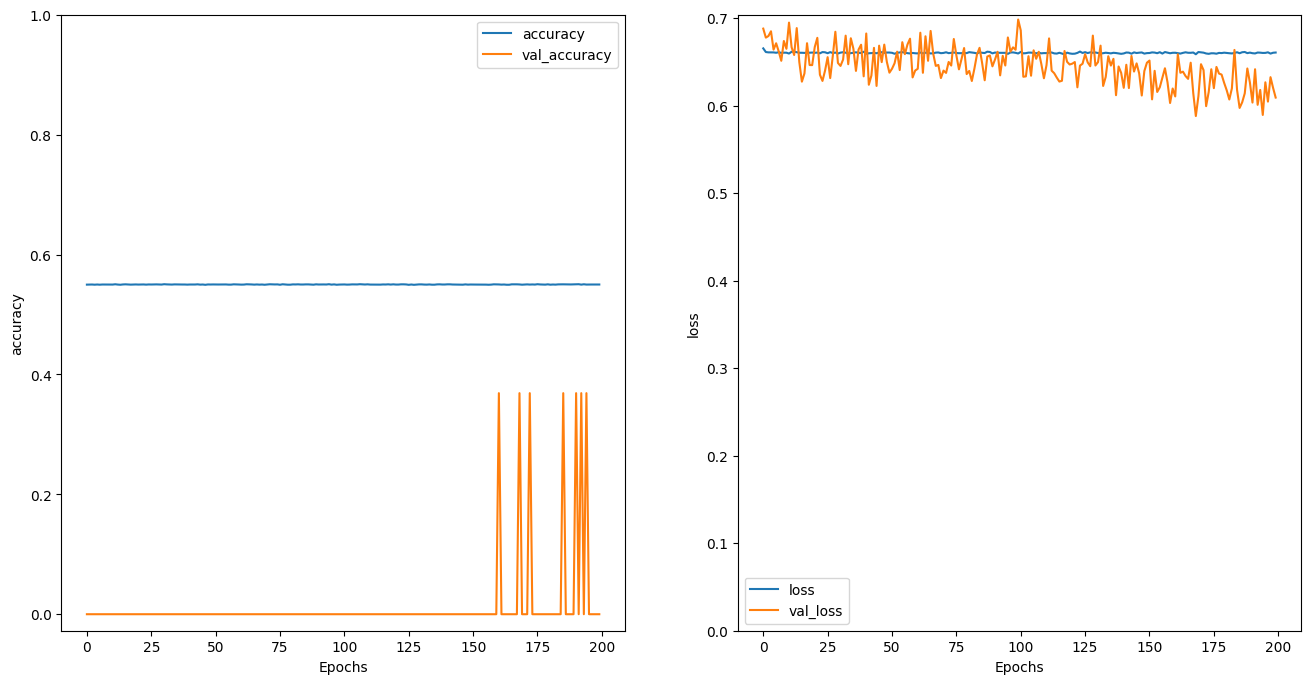

In [50]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [51]:
"""
# predict on a sample text without padding
predictions = model.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\npredictions = model.predict(np.array([sample_text]))\nprint(predictions[0])\n'

##### Experiment 5:

In [52]:
tokens_input_len = TOKENS_PAD_TO_MAX_TOKENS 
type_input_len = TYPE_TOKENS_PAD_TO_MAX_TOKENS

model_tf_idf = create_model(encoder_tf_idf_tokens, encoder_tf_idf_types,tokens_input_len, type_input_len) # maybe add 30

# predict on a sample formula using untrained model
#predictions = model_tf_idf.predict(np.array([sample_text]))
#print(predictions[0])

In [53]:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 200
sample_text = "set_constant SET_BASIC"

model_tf_idf.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(LEARNING_RATE),
              metrics=["accuracy"])

In [54]:
model_tf_idf.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization_8 (TextVect  (None, 150)         1           ['input_9[0][0]']                
 orization)                                                                                       
                                                                                                  
 text_vectorization_9 (TextVect  (None, 100)         1           ['input_10[0][0]']         

In [55]:
configs_dict = {
    "learning_rate": LEARNING_RATE,
    "algorithm": "LogReg",
    "configuration": "3-tokens-types",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "epochs": NUM_EPOCHS,
    "batch_size": 64,
    "vectorizer": "tf_idf",
    "dataset": "TOKENIZED_SET_V1"
}
run = wandb.init(project=wandb_project_name, reinit=True, config=configs_dict)

history = model_tf_idf.fit(train_dataset, 
                    epochs=NUM_EPOCHS,
                    validation_data=test_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VAL_STEPS_PER_EPOCH,
                    callbacks= [WandbCallback()])#[tensorboard_callback])
run.finish()

Epoch 1/200
152/156 [============================>.] - ETA: 0s - loss: 0.6848 - accuracy: 0.5505INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 18ms/step - loss: 0.6847 - accuracy: 0.5499 - val_loss: 0.7679 - val_accuracy: 0.0000e+00
Epoch 2/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6751 - accuracy: 0.5500 - val_loss: 0.7750 - val_accuracy: 0.0000e+00
Epoch 3/200
153/156 [============================>.] - ETA: 0s - loss: 0.6701 - accuracy: 0.5512INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6703 - accuracy: 0.5501 - val_loss: 0.7558 - val_accuracy: 0.0000e+00
Epoch 4/200
151/156 [============================>.] - ETA: 0s - loss: 0.6672 - accuracy: 0.5502INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6669 - accuracy: 0.5502 - val_loss: 0.7523 - val_accuracy: 0.0000e+00
Epoch 5/200
153/156 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.5516INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6664 - accuracy: 0.5513 - val_loss: 0.7463 - val_accuracy: 0.0000e+00
Epoch 6/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6630 - accuracy: 0.5534 - val_loss: 0.7622 - val_accuracy: 0.0000e+00
Epoch 7/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6641 - accuracy: 0.5550 - val_loss: 0.7780 - val_accuracy: 0.0000e+00
Epoch 8/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6629 - accuracy: 0.5579 - val_loss: 0.7612 - val_accuracy: 0.0000e+00
Epoch 9/200
154/156 [============================>.] - ETA: 0s - loss: 0.6623 - accuracy: 0.5582INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6623 - accuracy: 0.5575 - val_loss: 0.7337 - val_accuracy: 0.0063
Epoch 10/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6633 - accuracy: 0.5592 - val_loss: 0.7579 - val_accuracy: 0.0052
Epoch 11/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6626 - accuracy: 0.5594 - val_loss: 0.7345 - val_accuracy: 0.0063
Epoch 12/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6611 - accuracy: 0.5610INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6607 - accuracy: 0.5606 - val_loss: 0.7179 - val_accuracy: 0.0406
Epoch 13/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6624 - accuracy: 0.5612 - val_loss: 0.7264 - val_accuracy: 0.0115
Epoch 14/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6617 - accuracy: 0.5618 - val_loss: 0.7295 - val_accuracy: 0.0115
Epoch 15/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6611 - accuracy: 0.5637 - val_loss: 0.7676 - val_accuracy: 0.0052
Epoch 16/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6610 - accuracy: 0.5619 - val_loss: 0.7501 - val_accuracy: 0.0073
Epoch 17/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6612 - accuracy: 0.5620 - val_loss: 0.7796 - val_accuracy: 0.0052
Epoch 18/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6636 - accuracy: 0.5620 - val_loss: 0.7413 - val_accuracy: 0.0167
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6593 - accuracy: 0.5666 - val_loss: 0.7173 - val_accuracy: 0.0458
Epoch 30/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6611 - accuracy: 0.5665 - val_loss: 0.7532 - val_accuracy: 0.0167
Epoch 31/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6599 - accuracy: 0.5651 - val_loss: 0.7610 - val_accuracy: 0.0125
Epoch 32/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6601 - accuracy: 0.5627 - val_loss: 0.7515 - val_accuracy: 0.0167
Epoch 33/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6602 - accuracy: 0.5640 - val_loss: 0.7427 - val_accuracy: 0.0167
Epoch 34/200
150/156 [===========================>..] - ETA: 0s - loss: 0.6600 - accuracy: 0.5669INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6595 - accuracy: 0.5677 - val_loss: 0.7161 - val_accuracy: 0.0458
Epoch 35/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6622 - accuracy: 0.5650 - val_loss: 0.7523 - val_accuracy: 0.0167
Epoch 36/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6614 - accuracy: 0.5625 - val_loss: 0.7551 - val_accuracy: 0.0125
Epoch 37/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6606 - accuracy: 0.5642 - val_loss: 0.7379 - val_accuracy: 0.0167
Epoch 38/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6601 - accuracy: 0.5655 - val_loss: 0.7415 - val_accuracy: 0.0167
Epoch 39/200
155/156 [============================>.] - ETA: 0s - loss: 0.6599 - accuracy: 0.5644INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6597 - accuracy: 0.5649 - val_loss: 0.7146 - val_accuracy: 0.0458
Epoch 40/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6586 - accuracy: 0.5660 - val_loss: 0.7342 - val_accuracy: 0.0448
Epoch 41/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6615 - accuracy: 0.5676 - val_loss: 0.7386 - val_accuracy: 0.0448
Epoch 42/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6600 - accuracy: 0.5660 - val_loss: 0.7381 - val_accuracy: 0.0167
Epoch 43/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6579 - accuracy: 0.5672 - val_loss: 0.7227 - val_accuracy: 0.0458
Epoch 44/200
153/156 [============================>.] - ETA: 0s - loss: 0.6590 - accuracy: 0.5653INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6597 - accuracy: 0.5642 - val_loss: 0.7143 - val_accuracy: 0.0458
Epoch 45/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6599 - accuracy: 0.5677 - val_loss: 0.7243 - val_accuracy: 0.0458
Epoch 46/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6595 - accuracy: 0.5658 - val_loss: 0.7230 - val_accuracy: 0.0458
Epoch 47/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6609 - accuracy: 0.5673 - val_loss: 0.7344 - val_accuracy: 0.0448
Epoch 48/200
155/156 [============================>.] - ETA: 0s - loss: 0.6609 - accuracy: 0.5667INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 17ms/step - loss: 0.6607 - accuracy: 0.5670 - val_loss: 0.7119 - val_accuracy: 0.0458
Epoch 49/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6610 - accuracy: 0.5667 - val_loss: 0.7518 - val_accuracy: 0.0167
Epoch 50/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6608 - accuracy: 0.5664 - val_loss: 0.7437 - val_accuracy: 0.0448
Epoch 51/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6608 - accuracy: 0.5655 - val_loss: 0.7293 - val_accuracy: 0.0448
Epoch 52/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6598 - accuracy: 0.5661 - val_loss: 0.7325 - val_accuracy: 0.0448
Epoch 53/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6610 - accuracy: 0.5649 - val_loss: 0.7353 - val_accuracy: 0.0448
Epoch 54/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6589 - accuracy: 0.5670 - val_loss: 0.7180 - val_accuracy: 0.0448
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6603 - accuracy: 0.5652 - val_loss: 0.7113 - val_accuracy: 0.0458
Epoch 62/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6615 - accuracy: 0.5636 - val_loss: 0.7275 - val_accuracy: 0.0448
Epoch 63/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6592 - accuracy: 0.5671 - val_loss: 0.7277 - val_accuracy: 0.0167
Epoch 64/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6599 - accuracy: 0.5658 - val_loss: 0.7382 - val_accuracy: 0.0167
Epoch 65/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6599 - accuracy: 0.5658 - val_loss: 0.7349 - val_accuracy: 0.0448
Epoch 66/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6598 - accuracy: 0.5680 - val_loss: 0.7397 - val_accuracy: 0.0448
Epoch 67/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6604 - accuracy: 0.5666 - val_loss: 0.7245 - val_accuracy: 0.0458
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 16ms/step - loss: 0.6592 - accuracy: 0.5673 - val_loss: 0.7085 - val_accuracy: 0.0490
Epoch 87/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6601 - accuracy: 0.5653 - val_loss: 0.7355 - val_accuracy: 0.0177
Epoch 88/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6588 - accuracy: 0.5673 - val_loss: 0.7320 - val_accuracy: 0.0177
Epoch 89/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6588 - accuracy: 0.5672 - val_loss: 0.7173 - val_accuracy: 0.0500
Epoch 90/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6594 - accuracy: 0.5702 - val_loss: 0.7342 - val_accuracy: 0.0219
Epoch 91/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6599 - accuracy: 0.5645 - val_loss: 0.7098 - val_accuracy: 0.0500
Epoch 92/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6601 - accuracy: 0.5670 - val_loss: 0.7361 - val_accuracy: 0.0458
Epoc

INFO:tensorflow:Assets written to: /home/paul_d/Sources/sem_math_repo/classification_formulas_binary/wandb/run-20230307_233303-ywgmyeyh/files/model-best/assets


156/156 [==============================] - 3s 19ms/step - loss: 0.6584 - accuracy: 0.5656 - val_loss: 0.6957 - val_accuracy: 0.0583
Epoch 97/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6593 - accuracy: 0.5674 - val_loss: 0.7018 - val_accuracy: 0.0531
Epoch 98/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6584 - accuracy: 0.5662 - val_loss: 0.7542 - val_accuracy: 0.0167
Epoch 99/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6592 - accuracy: 0.5654 - val_loss: 0.7497 - val_accuracy: 0.0167
Epoch 100/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6600 - accuracy: 0.5648 - val_loss: 0.7477 - val_accuracy: 0.0167
Epoch 101/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6589 - accuracy: 0.5650 - val_loss: 0.7117 - val_accuracy: 0.0562
Epoch 102/200
156/156 [==============================] - 1s 8ms/step - loss: 0.6610 - accuracy: 0.5656 - val_loss: 0.7462 - val_accuracy: 0.0167
E

In [56]:
test_loss, test_acc = model_tf_idf.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

15/15 [==============================] - 0s 2ms/step - loss: 0.7226 - accuracy: 0.0490
Test Loss: 0.7226345539093018
Test Accuracy: 0.04895833507180214


(0.0, 0.7857233583927155)

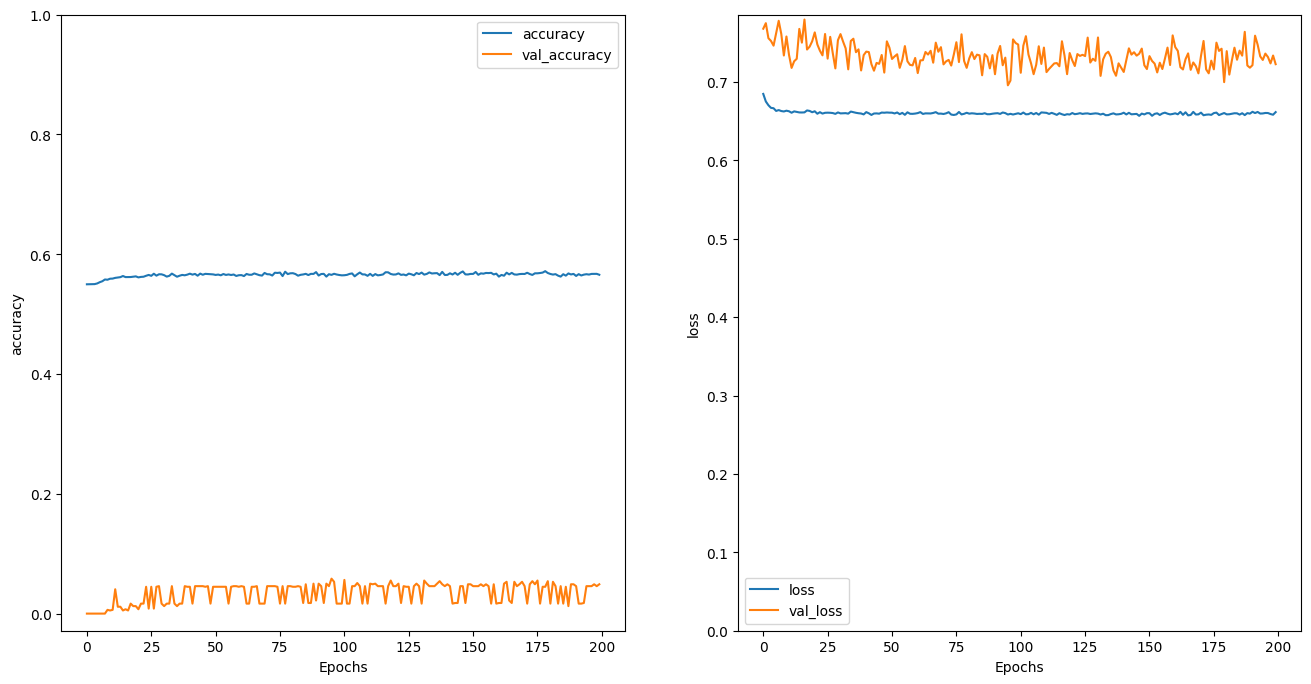

In [57]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, "accuracy")
plt.ylim(None, 1)
plt.subplot(1,2,2)
plot_graphs(history, "loss")
plt.ylim(0, None)

In [58]:
"""
# predict on a sample text without padding
sample_text = "set_constant SET_BASIC"
predictions = model_tf_idf.predict(np.array([sample_text]))
print(predictions[0])
"""

'\n# predict on a sample text without padding\nsample_text = "set_constant SET_BASIC"\npredictions = model_tf_idf.predict(np.array([sample_text]))\nprint(predictions[0])\n'